In [1]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pyzbar.pyzbar import decode

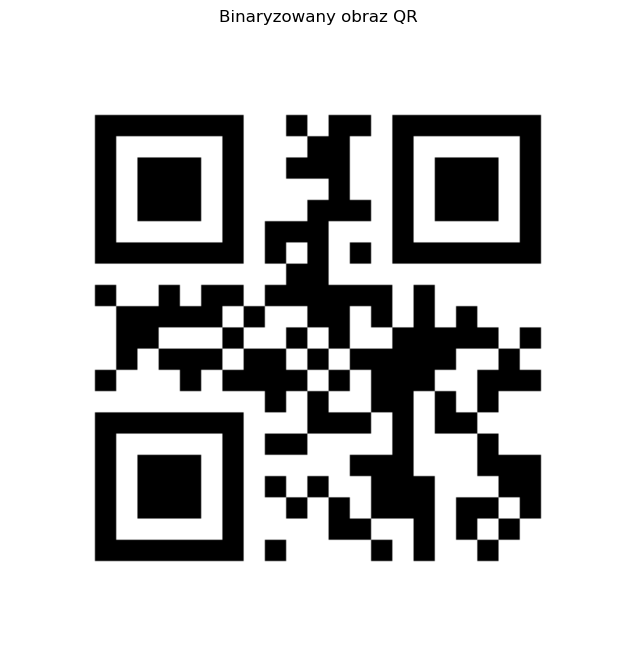

In [2]:
# Wczytanie obrazu i binaryzacja
image_path = r'qr_dataset\1011-v1.png'  # Podmień na ścieżkę do swojego pliku
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(8, 8))
plt.imshow(binary_image, cmap='gray')
plt.title("Binaryzowany obraz QR")
plt.axis("off")
plt.show()

In [3]:
# Wykrywanie konturów i Finder Patterns
contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

finder_patterns = []
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:  # Szukamy prostokątów
        area = cv2.contourArea(approx)
        if area > 100:  # Filtruj małe obszary
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            if 0.9 < aspect_ratio < 1.1:  # Kwadratowe proporcje
                finder_patterns.append(approx)
        


In [4]:
# Oblicz prostokątne obwiednie Finder Patterns
finder_patterns_bounds = [cv2.boundingRect(pattern) for pattern in finder_patterns]

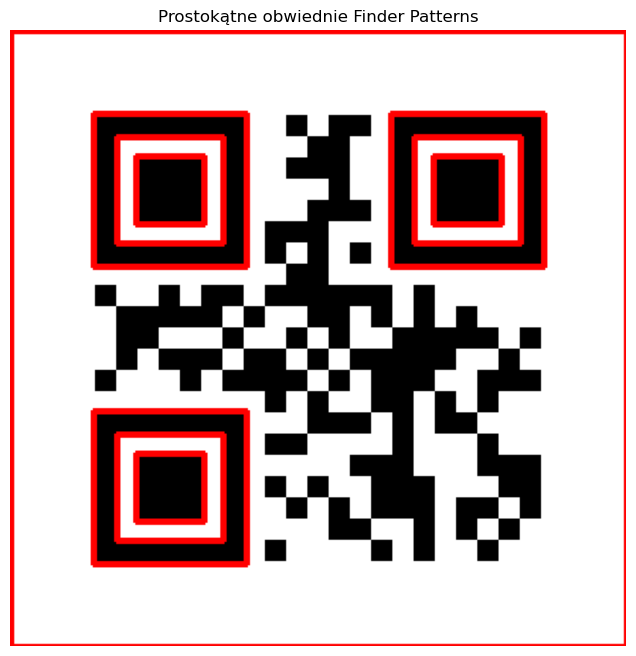

In [5]:
# Wyświetl prostokąty Finder Patterns na obrazie
pattern_image = image.copy()
for x, y, w, h in finder_patterns_bounds:
    cv2.rectangle(pattern_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(pattern_image, cv2.COLOR_BGR2RGB))
plt.title("Prostokątne obwiednie Finder Patterns")
plt.axis("off")
plt.show()

In [6]:
# Filtracja Finder Patterns
def filter_finder_patterns(finder_patterns_bounds, image_size, threshold_ratio=0.1):
    """
    Filtruje obiekty, które nie są częścią kodu QR, na podstawie wielkości i położenia.

    finder_patterns_bounds -- Lista prostokątnych obwiedni (x, y, w, h).
    image_size -- Rozmiar obrazu (szerokość, wysokość).
    threshold_ratio -- Maksymalny stosunek wielkości obiektu do obrazu (domyślnie 10%).
    """
    max_area = (image_size[0] * image_size[1]) * threshold_ratio
    filtered_patterns = []
    
    for x, y, w, h in finder_patterns_bounds:
        area = w * h
        if area < max_area:  # Usuwamy zbyt duże kontury
            filtered_patterns.append((x, y, w, h))
    
    return filtered_patterns

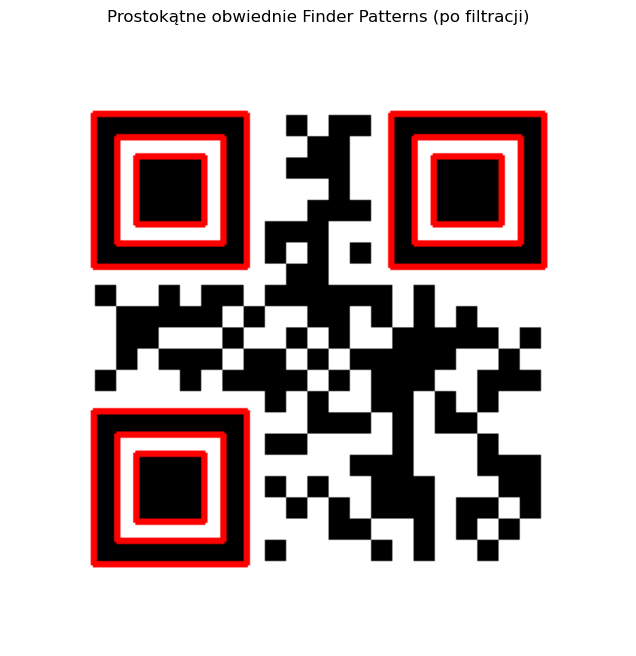

In [7]:
# Rozmiar obrazu
image_size = (binary_image.shape[1], binary_image.shape[0])

# Filtrowanie Finder Patterns
filtered_finder_patterns_bounds = filter_finder_patterns(finder_patterns_bounds, image_size)

# Wizualizacja po filtracji
pattern_image_filtered = image.copy()
for x, y, w, h in filtered_finder_patterns_bounds:
    cv2.rectangle(pattern_image_filtered, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(pattern_image_filtered, cv2.COLOR_BGR2RGB))
plt.title("Prostokątne obwiednie Finder Patterns (po filtracji)")
plt.axis("off")
plt.show()



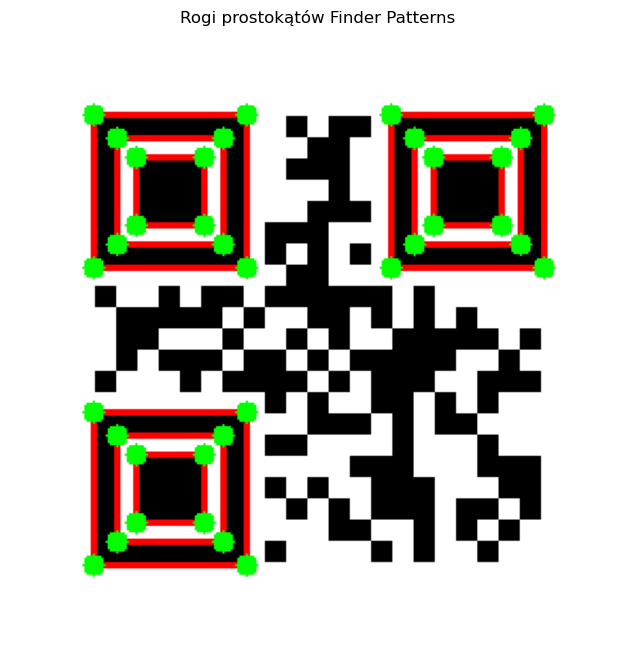

In [8]:
corners_image = pattern_image_filtered.copy()
for x, y, w, h in filtered_finder_patterns_bounds:
    corners = [(x, y), (x + w, y), (x, y + h), (x + w, y + h)]  # Rogi prostokąta
    for corner in corners:
        cv2.circle(corners_image, corner, 5, (0, 255, 0), -1)  # Zielone kropki

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(corners_image, cv2.COLOR_BGR2RGB))
plt.title("Rogi prostokątów Finder Patterns")
plt.axis("off")
plt.show()

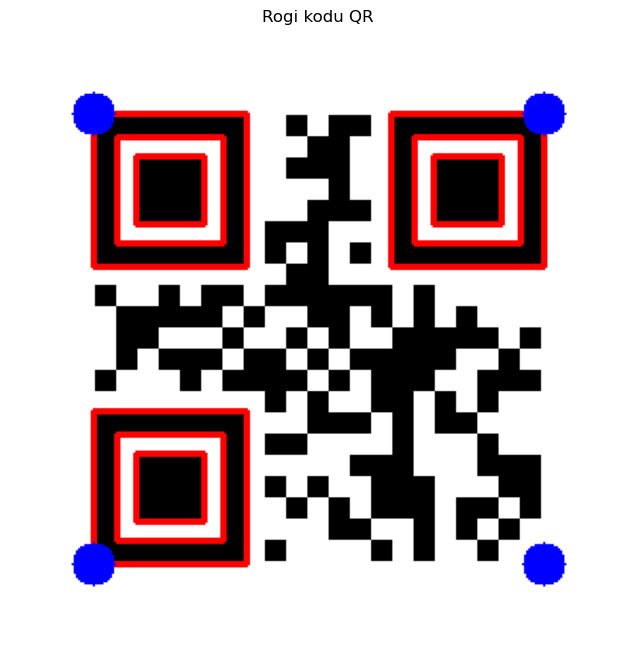

In [9]:
def get_qr_code_corners(finder_patterns_bounds):
    all_corners = []
    for x, y, w, h in finder_patterns_bounds:
        corners = [(x, y), (x + w, y), (x, y + h), (x + w, y + h)]
        all_corners.extend(corners)
    min_x = min(corner[0] for corner in all_corners)
    max_x = max(corner[0] for corner in all_corners)
    min_y = min(corner[1] for corner in all_corners)
    max_y = max(corner[1] for corner in all_corners)
    return (min_x, min_y), (max_x, min_y), (min_x, max_y), (max_x, max_y)

qr_corners = get_qr_code_corners(filtered_finder_patterns_bounds)
qr_corner_image = pattern_image_filtered.copy()
for corner in qr_corners:
    cv2.circle(qr_corner_image, corner, 10, (255, 0, 0), -1)  # Niebieskie kropki

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(qr_corner_image, cv2.COLOR_BGR2RGB))
plt.title("Rogi kodu QR")
plt.axis("off")
plt.show()


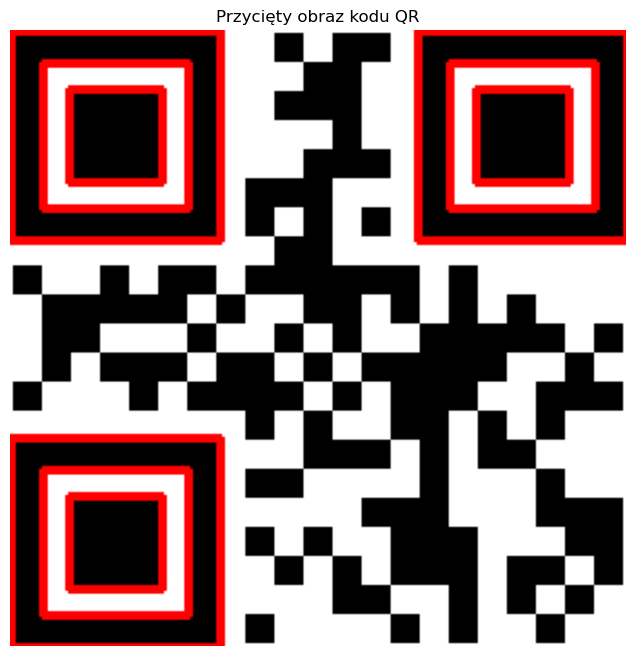

In [10]:

def crop_qr_code(image, corners):
    x_min = min(corners[0][0], corners[2][0])
    x_max = max(corners[1][0], corners[3][0])
    y_min = min(corners[0][1], corners[1][1])
    y_max = max(corners[2][1], corners[3][1])
    return image[y_min:y_max, x_min:x_max]

cropped_qr_image = crop_qr_code(pattern_image_filtered, qr_corners)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_qr_image, cv2.COLOR_BGR2RGB))
plt.title("Przycięty obraz kodu QR")
plt.axis("off")
plt.show()

[[1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1]
 [1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1]
 [1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1]
 [1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0]
 [0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1]
 [0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0]
 [1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0]
 [1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0]
 [1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0]
 [1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1]
 [1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1]
 [1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0]
 [1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0]]


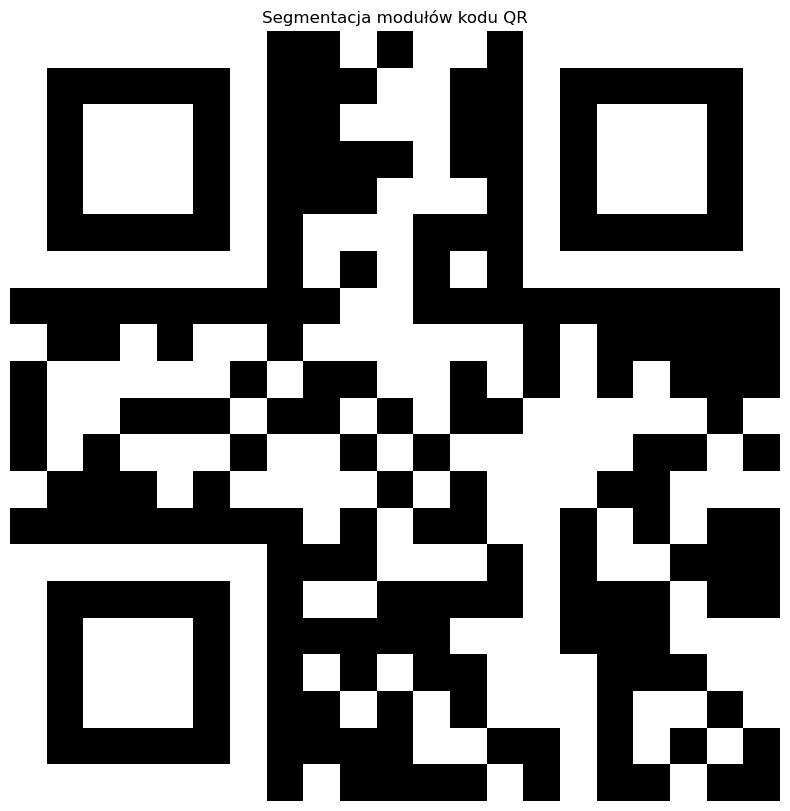

In [11]:
def segment_qr_code(image, grid_size):
    height, width = image.shape[:2]
    module_size = height // grid_size
    modules = []
    for row in range(grid_size):
        row_modules = []
        for col in range(grid_size):
            module = image[row * module_size:(row + 1) * module_size, col * module_size:(col + 1) * module_size]
            mean_intensity = np.mean(module)
            row_modules.append(1 if mean_intensity < 128 else 0)
        modules.append(row_modules)
    return np.array(modules)

if len(cropped_qr_image.shape) == 3:
    cropped_qr_gray = cv2.cvtColor(cropped_qr_image, cv2.COLOR_BGR2GRAY)
else:
    cropped_qr_gray = cropped_qr_image

modules = segment_qr_code(cropped_qr_gray, grid_size=21)

print(modules)

plt.figure(figsize=(10, 10))
plt.imshow(modules, cmap="gray", interpolation="nearest")
plt.title("Segmentacja modułów kodu QR")
plt.axis("off")
plt.show()

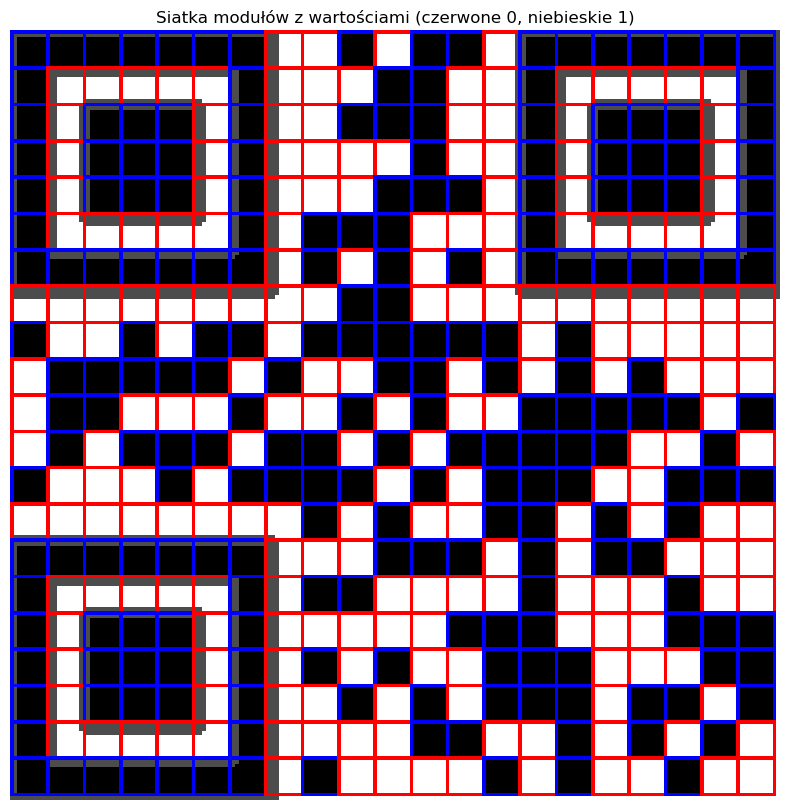

In [12]:
def visualize_modules_with_colored_values_no_text(image, modules):
    grid_size = modules.shape[0]
    module_size = image.shape[0] // grid_size
    overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    for row in range(grid_size):
        for col in range(grid_size):
            x1 = col * module_size
            y1 = row * module_size
            x2 = x1 + module_size
            y2 = y1 + module_size
            value = modules[row, col]
            color = (255, 0, 0) if value == 1 else (0, 0, 255)
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Siatka modułów z wartościami (czerwone 0, niebieskie 1)")
    plt.axis("off")
    plt.show()

visualize_modules_with_colored_values_no_text(cropped_qr_gray, modules)

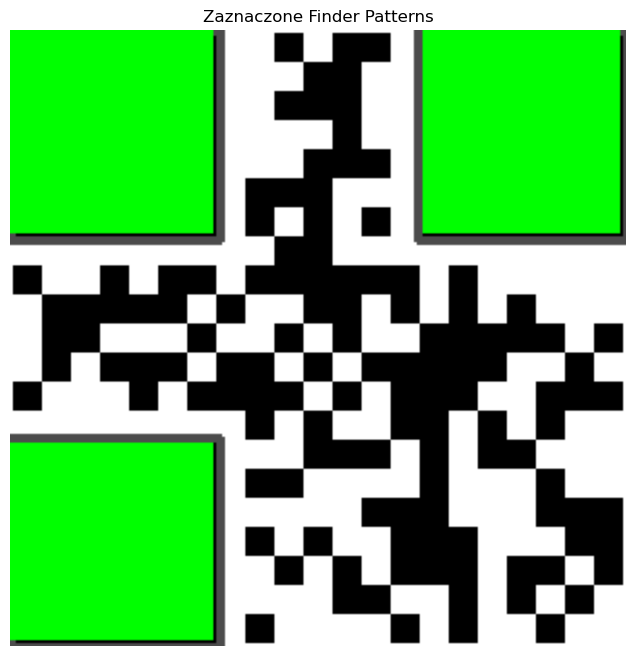

In [13]:
def highlight_finder_patterns(image, modules):
    """
    Zaznacza Finder Patterns na obrazie kodu QR.

    Args:
    image -- Obraz kodu QR w skali szarości lub kolorowy (numpy array).
    modules -- Tablica 2D reprezentująca siatkę modułów kodu QR.

    Returns:
    overlay -- Obraz z zaznaczonymi Finder Patterns.
    """
    # Tworzymy kopię obrazu
    overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    
    # Współrzędne dla Finder Patterns
    finder_coordinates = [
        (slice(0, 7), slice(0, 7)),      # Lewy górny róg
        (slice(0, 7), slice(-7, None)),  # Prawy górny róg
        (slice(-7, None), slice(0, 7))   # Lewy dolny róg
    ]

    # Ustalanie rozmiaru modułu
    module_size = image.shape[0] // modules.shape[0]

    # Iteracja przez Finder Patterns i zaznaczanie na zielono
    for coords in finder_coordinates:
        y_range, x_range = coords

        # Obsługa przypadków, gdzie `start` lub `stop` w slice jest `None`
        y_start = y_range.start if y_range.start is not None else modules.shape[0]
        y_stop = y_range.stop if y_range.stop is not None else modules.shape[0]
        x_start = x_range.start if x_range.start is not None else modules.shape[1]
        x_stop = x_range.stop if x_range.stop is not None else modules.shape[1]

        # Zaznaczenie Finder Patterns
        overlay[y_start * module_size:y_stop * module_size, x_start * module_size:x_stop * module_size] = (0, 255, 0)  # Zielony

    return overlay

# Zastosowanie funkcji do przyciętego obrazu QR
highlighted_finder_patterns = highlight_finder_patterns(cropped_qr_gray, modules)

# Wyświetlenie wyniku
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(highlighted_finder_patterns, cv2.COLOR_BGR2RGB))
plt.title("Zaznaczone Finder Patterns")
plt.axis("off")
plt.show()


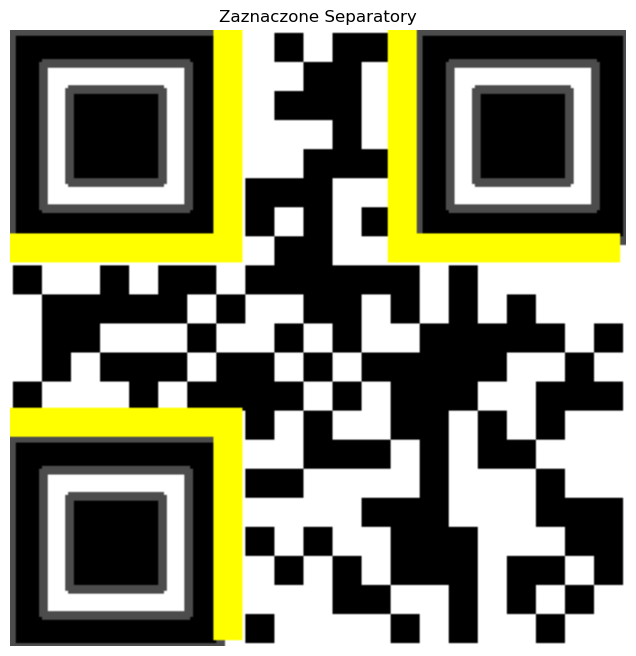

In [14]:
def highlight_separators(image, modules):
    """
    Zaznacza na obrazie Separatory wokół Finder Patterns w kodzie QR.

    Args:
    image -- Obraz kodu QR w skali szarości lub kolorowy (numpy array).
    modules -- Tablica 2D reprezentująca siatkę modułów kodu QR.

    Returns:
    overlay -- Obraz z zaznaczonymi Separatorami.
    """
    # Tworzymy kopię obrazu
    overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Rozmiar siatki i modułu
    grid_size = modules.shape[0]
    module_size = image.shape[0] // grid_size

    # Koordynaty Separatorów dla każdego Finder Pattern
    separator_coords = [
        # Lewy górny Finder Pattern
        (slice(0, 7), slice(7, 8)),  # Pionowy separator
        (slice(7, 8), slice(0, 8)),  # Poziomy separator
        # Prawy górny Finder Pattern
        (slice(0, 7), slice(grid_size - 8, grid_size - 7)),  # Pionowy separator
        (slice(7, 8), slice(grid_size - 8, grid_size)),  # Poziomy separator
        # Lewy dolny Finder Pattern
        (slice(grid_size - 8, grid_size - 7), slice(0, 8)),  # Poziomy separator
        (slice(grid_size - 7, grid_size), slice(7, 8))  # Pionowy separator
    ]

    # Zaznaczanie Separatorów
    for coord in separator_coords:
        y_range, x_range = coord
        overlay[
            y_range.start * module_size : y_range.stop * module_size,
            x_range.start * module_size : x_range.stop * module_size,
        ] = (0, 255, 255)  # Biały kolor

    return overlay

# Zastosowanie funkcji do przyciętego obrazu QR
highlighted_separators = highlight_separators(cropped_qr_gray, modules)

# Wyświetlenie wyniku
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(highlighted_separators, cv2.COLOR_BGR2RGB))
plt.title("Zaznaczone Separatory")
plt.axis("off")
plt.show()



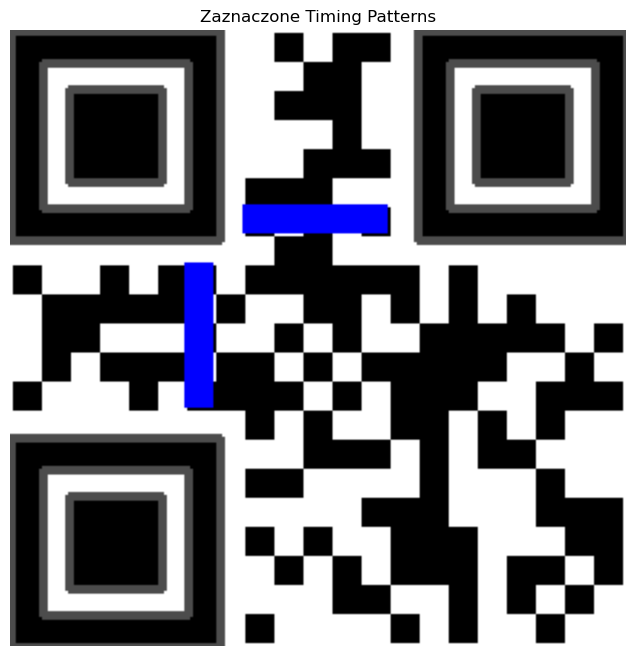

In [15]:
def highlight_timing_patterns(image, modules):
    """
    Zaznacza na obrazie Timing Patterns w kodzie QR.

    Args:
    image -- Obraz kodu QR w skali szarości lub kolorowy (numpy array).
    modules -- Tablica 2D reprezentująca siatkę modułów kodu QR.

    Returns:
    overlay -- Obraz z zaznaczonymi Timing Patterns.
    """
    # Tworzymy kopię obrazu
    overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Rozmiar siatki i modułu
    grid_size = modules.shape[0]
    module_size = image.shape[0] // grid_size

    # Poziomy Timing Pattern
    for col in range(8, grid_size - 8):
        x_start = col * module_size
        y_start = 6 * module_size
        x_end = x_start + module_size
        y_end = y_start + module_size
        overlay[y_start:y_end, x_start:x_end] = (255, 0, 0)  # Niebieski

    # Pionowy Timing Pattern
    for row in range(8, grid_size - 8):
        x_start = 6 * module_size
        y_start = row * module_size
        x_end = x_start + module_size
        y_end = y_start + module_size
        overlay[y_start:y_end, x_start:x_end] = (255, 0, 0)  # Niebieski

    return overlay

# Zastosowanie funkcji do przyciętego obrazu QR
highlighted_timing_patterns = highlight_timing_patterns(cropped_qr_gray, modules)

# Wyświetlenie wyniku
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(highlighted_timing_patterns, cv2.COLOR_BGR2RGB))
plt.title("Zaznaczone Timing Patterns")
plt.axis("off")
plt.show()


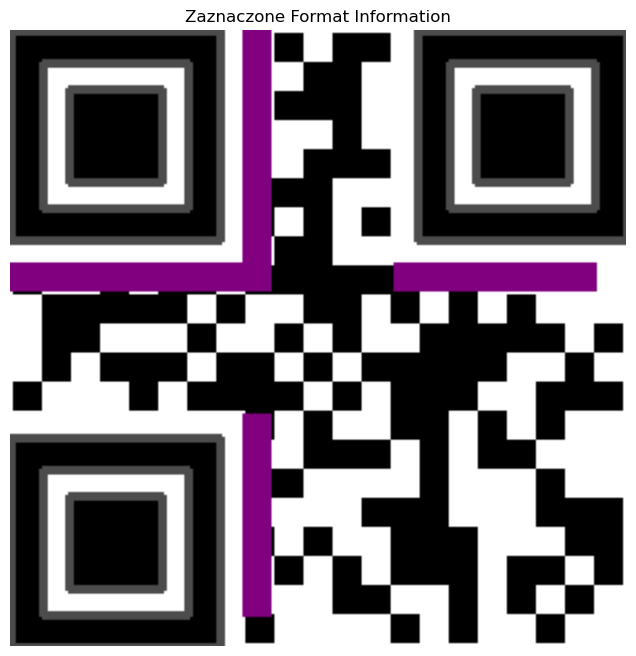

In [16]:
def highlight_format_information(image, modules):
    """
    Podświetla sekcje Format Information na obrazie QR.

    Args:
    image -- Przycięty obraz kodu QR (numpy array).
    modules -- Tablica modułów QR (1 = czarny, 0 = biały).

    Returns:
    overlay -- Obraz z podświetlonymi sekcjami Format Information.
    """
    # Kopia obrazu
    overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    
    # Rozmiar modułu i siatki
    grid_size = modules.shape[0]
    module_size = image.shape[0] // grid_size

    # Koordynaty Format Information
    format_info_coords = [
        (slice(0, 9), slice(8, 9)),  # Pionowa sekcja przy lewym Finder
        (slice(8, 9), slice(0, 9)),  # Pozioma sekcja przy górnym Finder
        (slice(-8, -1), slice(8, 9)),  # Pionowa sekcja przy dolnym Finder (jeśli istnieje)
        (slice(8, 9), slice(-8, -1)),  # Pozioma sekcja przy prawym Finder (jeśli istnieje)
    ]
    
    # Podświetlenie sekcji Format Information
    for coord in format_info_coords:
        y_range, x_range = coord
        overlay[y_range.start * module_size:y_range.stop * module_size,
                x_range.start * module_size:x_range.stop * module_size] = (128, 0, 128) 

    return overlay

# Zastosowanie funkcji do przyciętego obrazu QR
highlighted_format_info = highlight_format_information(cropped_qr_gray, modules)

# Wyświetlenie wyniku
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(highlighted_format_info, cv2.COLOR_BGR2RGB))
plt.title("Zaznaczone Format Information")
plt.axis("off")
plt.show()


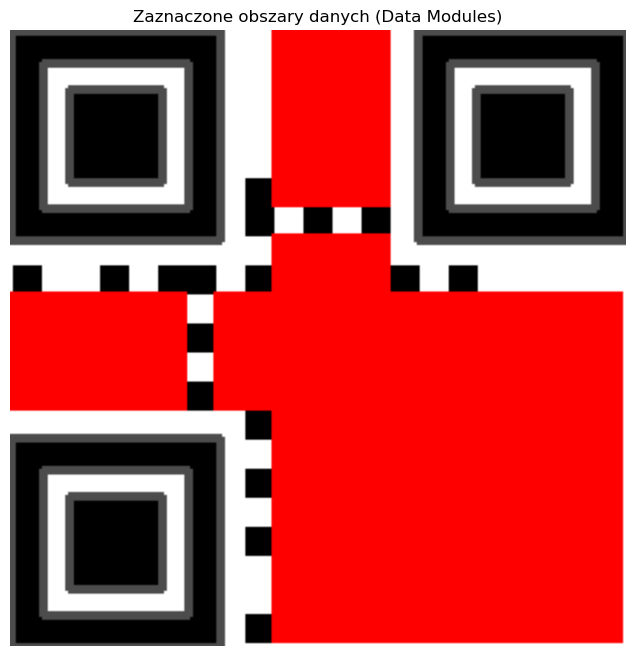

In [17]:


def highlight_data_modules_corrected(image, modules):
    """
    Zaznacza na obrazie QR kodu obszar danych (Data Modules) zgodnie z wymaganiami standardu QR Code w wersji 1.

    Arguments:
    image -- Przycięty obraz QR Code (numpy array).
    modules -- 2D array reprezentujący siatkę modułów QR Code.

    Returns:
    overlay -- Obraz z zaznaczonym obszarem danych.
    """
    # Rozmiar siatki i modułu
    grid_size = modules.shape[0]
    module_size = image.shape[0] // grid_size

    # Tworzenie kopii obrazu
    overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Iteracja przez siatkę modułów QR Code
    for row in range(grid_size):
        for col in range(grid_size):
            # Sprawdzenie, czy moduł należy do obszaru danych (Data Modules)
            if (
                not (row < 9 and col < 9)  # Lewy górny Finder Pattern
                and not (row < 9 and col >= grid_size - 8)  # Prawy górny Finder Pattern
                and not (row >= grid_size - 8 and col < 9)  # Lewy dolny Finder Pattern
                and not (row == 6 or col == 6)  # Timing Patterns
                and not (row == 8 and (col < 9 or col >= grid_size - 8))  # Format Info poziome
                and not (col == 8 and (row < 9 or row >= grid_size - 8))  # Format Info pionowe
                and not (row == 8 and col == 13)  # Dark Module
            ):
                # Współrzędne modułu
                x1 = col * module_size
                y1 = row * module_size
                x2 = x1 + module_size
                y2 = y1 + module_size

                # Kolor zaznaczenia dla modułów danych
                color = (0, 0, 255)  # Czerwony
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)  # Wypełnione prostokąty

    return overlay

# Zastosowanie funkcji do przyciętego obrazu QR
highlighted_data_modules = highlight_data_modules_corrected(cropped_qr_gray, modules)

# Wyświetlenie wyniku
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(highlighted_data_modules, cv2.COLOR_BGR2RGB))
plt.title("Zaznaczone obszary danych (Data Modules)")
plt.axis("off")
plt.show()


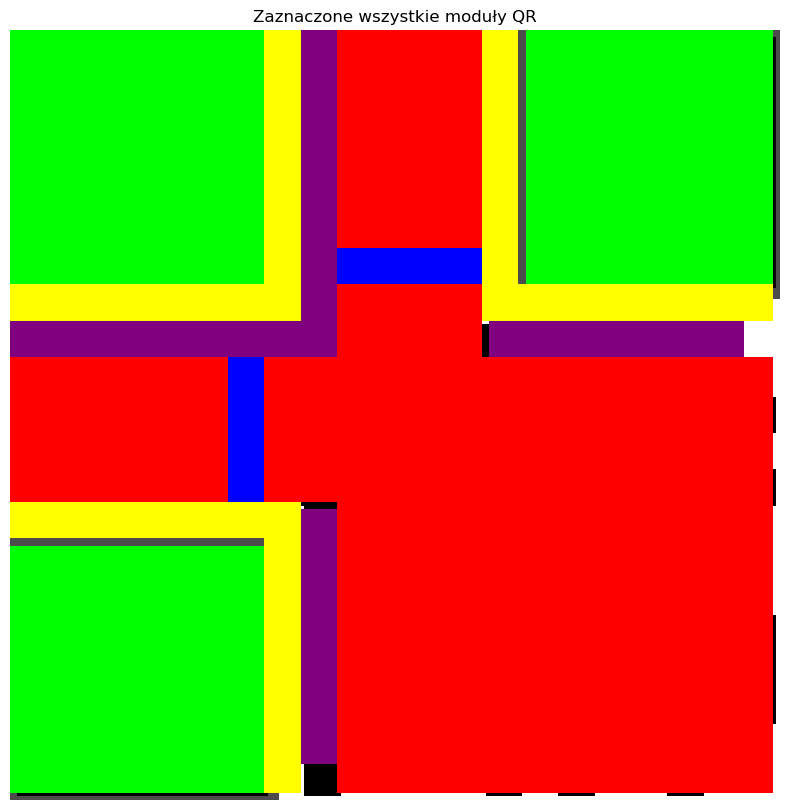

In [18]:
def highlight_all_modules(image, modules):
    """
    Nakłada wszystkie warstwy (Finder Patterns, Separatory, Timing Patterns, Format Information, Data Modules) 
    na obraz QR Code.

    Arguments:
    image -- Przycięty obraz QR Code (numpy array).
    modules -- 2D array reprezentująca siatkę modułów QR Code.

    Returns:
    overlay -- Obraz z zaznaczonymi wszystkimi komponentami QR Code.
    """
    # Tworzymy kopię obrazu
    overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # Rozmiar siatki i modułu
    grid_size = modules.shape[0]
    module_size = image.shape[0] // grid_size

    # Dodaj Finder Patterns (zielone)
    finder_coordinates = [
        (slice(0, 7), slice(0, 7)),      # Lewy górny róg
        (slice(0, 7), slice(-7, None)),  # Prawy górny róg
        (slice(-7, None), slice(0, 7))   # Lewy dolny róg
    ]
    for coords in finder_coordinates:
        y_range, x_range = coords
        y_start = (y_range.start or 0) * module_size
        y_stop = (y_range.stop or grid_size) * module_size
        x_start = (x_range.start or 0) * module_size
        x_stop = (x_range.stop or grid_size) * module_size
        overlay[y_start:y_stop, x_start:x_stop] = (0, 255, 0)  # Zielony

    # Dodaj Separatory (biały)
    separator_coords = [
        # Lewy górny Finder Pattern
        (slice(0, 7), slice(7, 8)),  # Pionowy separator
        (slice(7, 8), slice(0, 8)),  # Poziomy separator
        # Prawy górny Finder Pattern
        (slice(0, 7), slice(grid_size - 8, grid_size - 7)),
        (slice(7, 8), slice(grid_size - 8, grid_size)),
        # Lewy dolny Finder Pattern
        (slice(grid_size - 8, grid_size - 7), slice(0, 8)),
        (slice(grid_size - 7, grid_size), slice(7, 8))
    ]
    for coord in separator_coords:
        y_range, x_range = coord
        y_start = y_range.start * module_size
        y_stop = y_range.stop * module_size
        x_start = x_range.start * module_size
        x_stop = x_range.stop * module_size
        overlay[y_start:y_stop, x_start:x_stop] = (0, 255, 255)  # Biały

    # Dodaj Timing Patterns (niebieski)
    for i in range(8, grid_size - 8):
        overlay[6 * module_size:(6 + 1) * module_size, i * module_size:(i + 1) * module_size] = (255, 0, 0)  # Poziomy
        overlay[i * module_size:(i + 1) * module_size, 6 * module_size:(6 + 1) * module_size] = (255, 0, 0)  # Pionowy

    # Dodaj Format Information (fioletowy)
    format_info_coords = [
        (slice(0, 9), slice(8, 9)),  # Lewy górny pionowo
        (slice(8, 9), slice(0, 9)),  # Lewy górny poziomo
        (slice(-8, -1), slice(8, 9)),  # Dolny Finder pionowo
        (slice(8, 9), slice(-8, -1))  # Prawy Finder poziomo
    ]
    for coord in format_info_coords:
        y_range, x_range = coord
        y_start = y_range.start * module_size
        y_stop = y_range.stop * module_size
        x_start = x_range.start * module_size
        x_stop = x_range.stop * module_size
        overlay[y_start:y_stop, x_start:x_stop] = (128, 0, 128)  # Fioletowy

    # Dodaj Data Modules (czerwony)
    for row in range(grid_size):
        for col in range(grid_size):
            if (
                not (row < 9 and col < 9) and  # Lewy górny Finder Pattern
                not (row < 9 and col >= grid_size - 8) and  # Prawy górny Finder Pattern
                not (row >= grid_size - 8 and col < 9) and  # Lewy dolny Finder Pattern
                not (row == 6 or col == 6) and  # Timing Patterns
                not (row == 8 and (col < 9 or col >= grid_size - 8)) and  # Format Info
                not (col == 8 and (row < 9 or row >= grid_size - 8)) and  # Format Info
                not (row == grid_size - 8 and col == 8)  # Dark Module
            ):
                x1, y1 = col * module_size, row * module_size
                x2, y2 = x1 + module_size, y1 + module_size
                overlay[y1:y2, x1:x2] = (0, 0, 255)  # Czerwony

    return overlay

# %% Zastosowanie funkcji do przyciętego obrazu QR
highlighted_all_modules = highlight_all_modules(cropped_qr_gray, modules)

# Wyświetlenie wyniku
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(highlighted_all_modules, cv2.COLOR_BGR2RGB))
plt.title("Zaznaczone wszystkie moduły QR")
plt.axis("off")
plt.show()


In [19]:

def generate_image_from_matrix(matrix):
    """
    Tworzy obraz QR z macierzy 0 i 1.
    
    Args:
    matrix -- Lista list (0 i 1) reprezentująca QR Code.

    Returns:
    img -- Obraz Pillow.
    """
    size = len(matrix)
    # Konwersja macierzy do obrazu
    img = Image.fromarray(np.array(matrix) * 255).convert('L')  # 0 -> czarny, 1 -> biały
    img = img.resize((size * 10, size * 10), Image.NEAREST)  # Powiększenie dla poprawy czytelności
    return img


def read_qr_from_image(image):
    """
    Odczytuje dane z obrazu QR Code za pomocą pyzbar.
    
    Args:
    image -- Obraz Pillow (QR Code).

    Returns:
    Decoded message or None.
    """
    decoded_objects = decode(image)
    if decoded_objects:
        return decoded_objects[0].data.decode('utf-8')  # Zwraca pierwszą odczytaną wiadomość
    return None


# Przykładowa macierz QR Code
def invert_matrix(matrix):
    """
    Inverts a binary matrix (0 -> 1, 1 -> 0).

    Arguments:
    matrix -- List of lists containing binary values.

    Returns:
    inverted_matrix -- Inverted binary matrix.
    """
    inverted_matrix = [[1 - value for value in row] for row in matrix]
    return inverted_matrix


qr_matrix = invert_matrix(modules)
# Invert the given matrix
inverted_qr_matrix = invert_matrix(qr_matrix)



# Tworzenie obrazu QR z macierzy
qr_image = generate_image_from_matrix(qr_matrix)



# Odczyt wiadomości z obrazu QR
decoded_message = read_qr_from_image(qr_image)
print(f"Odkodowana wiadomość: {decoded_message}")


Odkodowana wiadomość: 1011
